In [2169]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import streamlit as st
from joblib import dump

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2170]:
df = pd.read_csv('main_data.csv')
df = df.rename({'isСomplete': 'is_complete', 'complitation_year': 'completion_year'}, axis=1)

df_msk = pd.read_csv('data_msk.csv')
df_spb = pd.read_csv('data_spb.csv')
df_ekb = pd.read_csv('data_ekb.csv')
df_nsk = pd.read_csv('data_nsk.csv')
df_kzn = pd.read_csv('data_kzn.csv')
df_nng = pd.read_csv('data_nng.csv')

df = pd.concat([df, df_msk, df_spb, df_ekb, df_nsk, df_kzn, df_nng], axis=0)
np.mean(df['price']), np.median(df['price']), df.shape

df[['metro_distance', 'metro_transport']]

,metro_distance,metro_transport
0,"6,10,4","walk,walk,transport"
1,"6,9,13","walk,walk,walk"
2,"3,6","walk,walk"
3,"10,10,10","walk,walk,walk"
4,"3,6","walk,walk"
...,...,...
1381,NaN,NaN
1382,6,walk
1383,NaN,NaN
1384,6,transport


In [2171]:
df['region'].value_counts()

spb    2467
msk    2463
kzn    2404
nng    2386
ekb    2383
nsk    2382
Name: region, dtype: int64

In [2172]:
print(df.duplicated().sum())
df = df.drop_duplicates()
df.duplicated().sum()

0


0

## Price Isolation Forest

In [2173]:
def outlier_plot(data, x_var, y_var, xaxis_limits=[0,1], yaxis_limits=[0,1]):
    
    print('Число аномальных значений: ', len(data[data['anomaly']==-1]))
    print('Число нормальных значений: ', len(data[data['anomaly']==1]))
    print('Общее число значений: ', len(data))
    
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1, -1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle('Isolation forest', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f'Выбросы:\n{len(data[data["anomaly"]==-1])}')
    axes[1].set_title(f'Не выбросы:\n{len(data[data["anomaly"]==1])}')
    return g

In [2174]:
price_if = IsolationForest(contamination='auto', random_state=42)
price_if.fit(df[['price']])
df['price_anomaly'] = price_if.predict(df[['price']])
df['price_anomaly'].value_counts()

 1    12205
-1     2280
Name: price_anomaly, dtype: int64

## Total Area Isolation Forest

In [2175]:
total_area_if = IsolationForest(contamination='auto', random_state=42)
total_area_if.fit(df[['total_area']])
df['total_area_anomaly'] = total_area_if.predict(df[['total_area']])
df['total_area_anomaly'].value_counts()

 1    12271
-1     2214
Name: total_area_anomaly, dtype: int64

In [2176]:
df = df.iloc[df[(df['price_anomaly'] == 1) | (df['total_area_anomaly'] == 1)].index].reset_index(drop=True)
df = df.drop(['price_anomaly', 'total_area_anomaly'], axis=1)

<AxesSubplot:xlabel='price', ylabel='Density'>

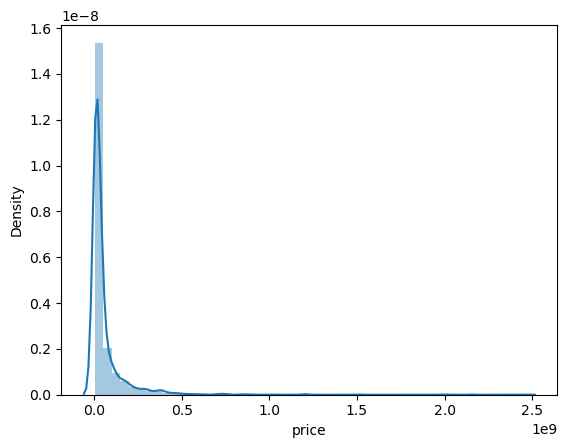

In [2177]:
sns.distplot(df['price'])

<AxesSubplot:xlabel='total_area', ylabel='Density'>

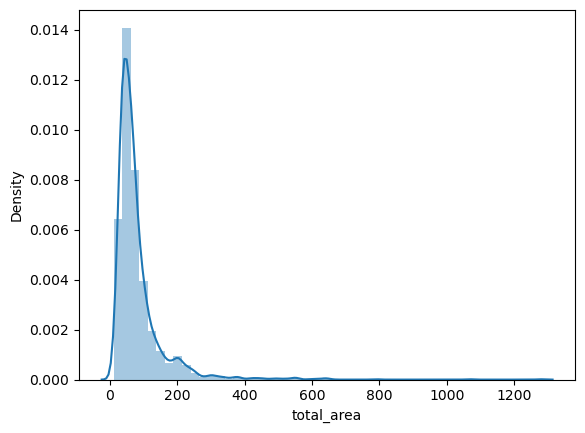

In [2178]:
sns.distplot(df['total_area'])

## Работа с пропусками

In [2179]:
# is_complete, в зависимости от completion_year, build_date и is_auction 
# (будем считать, что большинство квартир на аукционе уже сданы)

df.loc[:, ['is_complete']] = df.apply(lambda x:
    int(x.completion_year < 2024) if pd.isna(x.is_complete) and not pd.isna(x.completion_year) else x.is_complete, axis=1
)

df.loc[:, ['is_complete']] = df.apply(lambda x: 
    int(x.build_date < 2024) if pd.isna(x.is_complete) and not pd.isna(x.build_date) else x.is_complete, axis=1
)

df.loc[:, ['is_complete']] = df.apply(lambda x:
    int(x.is_auction) if pd.isna(x.is_complete) else x.is_complete, axis=1)

In [2180]:
# decoration, зависит от is_complete (если дом не был сдан, то скорее всего отделки еще нет)
df.loc[:, ['decoration']] = df.apply(lambda x:
    'without' if pd.isna(x.decoration) and not x.is_complete else x.decoration, axis=1
)

In [2181]:
# заполняем тип материала дома по году постройки и количеству этажей 
# как правило, 5-этажные и 9-этажные дома панельные
# 'stalin' отнесем к кирпичным домам, удалим 'old', 'wood', 'gasSilicateBlock'

df.loc[:, ['house_material']] = df.apply(lambda x:
    'panel' if pd.isna(x.house_material) and x.floors_number in (5, 9) else x.house_material, axis=1
)

df.loc[df['house_material'] == 'stalin', 'house_material'] = 'brick'
df = df[(df['house_material'] != 'old') & (df['house_material'] != 'wood') & (df['house_material'] != 'gasSilicateBlock')]

In [2182]:
# пассажирские лифты (если 5 этажей и тип "panel" – 0, если 9 этажей – 1, от 10 до 19 – минимум два лифта, от 20 – 3 или 4)
df.loc[:, ['passenger_elevator']] = df.apply(lambda x:
    0 if pd.isna(x.passenger_elevator) 
    and x.floors_number in np.arange(1, 4) else x.passenger_elevator, axis=1
)

df.loc[:, ['passenger_elevator']] = df.apply(lambda x:
    0 if pd.isna(x.passenger_elevator) 
    and x.house_material in ('brick', 'panel') 
    and x.floors_number == 5 else x.passenger_elevator, axis=1
)

df.loc[:, ['passenger_elevator']] = df.apply(lambda x:
    1 if pd.isna(x.passenger_elevator) 
    and x.floors_number == 9 else x.passenger_elevator, axis=1
)

df.loc[:, ['passenger_elevator']] = df.apply(lambda x:
    2 if pd.isna(x.passenger_elevator) 
    and x.floors_number in np.arange(10, 20) else x.passenger_elevator, axis=1
)

df.loc[:, ['passenger_elevator']] = df.apply(lambda x:
    3 if pd.isna(x.passenger_elevator) 
    and x.floors_number in np.arange(20, 26) else x.passenger_elevator, axis=1
)

In [2183]:
# грузовые лифты (до 5 этажей – 0, от 5 до 9 этажей, предположим, что 0, так как единственный пассажирский)

df.loc[:, ['cargo_elevator']] = df.apply(lambda x:
    0 if pd.isna(x.cargo_elevator) 
    and x.floors_number in np.arange(1, 10) else x.cargo_elevator, axis=1
)

df.loc[:, ['cargo_elevator']] = df.apply(lambda x:
    1 if pd.isna(x.cargo_elevator) 
    and x.floors_number in np.arange(10, 13)
    and x.passenger_elevator == 0 else x.cargo_elevator, axis=1
)

df.loc[:, ['cargo_elevator']] = df.apply(lambda x:
    1 if pd.isna(x.cargo_elevator) 
    and x.floors_number in np.arange(13, 23)
    and x.passenger_elevator in (1, 2) else x.cargo_elevator, axis=1
)

df.loc[:, ['cargo_elevator']] = df.apply(lambda x:
    2 if pd.isna(x.cargo_elevator) 
    and x.floors_number in np.arange(23, 30)
    and x.passenger_elevator in (1, 2) else x.cargo_elevator, axis=1
)

In [2184]:
# парковка (если не указана – open)
df.loc[:, ['parking']] = df.apply(lambda x:
    'open' if pd.isna(x.parking) else x.parking, axis=1
)

## Создание признаков

In [2185]:
# возраст дома
df['house_age'] = 2024 - df['build_date']

df.loc[:, ['house_age']] = df.apply(lambda x:
     0 if pd.isna(x.house_age) and x.is_complete == 0 else x.house_age, axis=1                         
)

df.loc[:, ['house_age']] = df.apply(lambda x:
    2024 - x.completion_year if pd.isna(x.house_age) and x.is_complete == 1 else x.house_age, axis=1
)
df['house_age'].isnull().sum()

1458

In [2186]:
# первый этаж

df.loc[:, ['is_first_floor']] = df.apply(lambda x:
    1 if x.floor == 1 else 0, axis=1
)
df['is_first_floor'].value_counts()

0    12407
1      655
Name: is_first_floor, dtype: int64

In [2187]:
# последний этаж

df.loc[:, ['is_last_floor']] = df.apply(lambda x:
    1 if x.floor == x.floors_number else 0, axis=1
)
df['is_last_floor'].value_counts()

0    12087
1      975
Name: is_last_floor, dtype: int64

In [2188]:
# есть ли метро в шаговой/транспортной доступности

df.loc[:, ['has_metro']] = df.apply(lambda x:
   0 if pd.isna(x.metro) else 1, axis=1                                
)

In [2189]:
# среднее время до метро
# ввести повышающий/понижающий коэф
# отношение скоростей
df.loc[:, ['mean_metro']] = df.apply(lambda x:
    0 if x.has_metro == 0 else sum(map(float, x.metro_distance.split(',')))/3, axis=1
)

In [2193]:
def calculate_mean_distance(row):
    distances = [int(x) for x in str(row['metro_distance']).split(',') if x.isdigit()]
    transports = str(row['metro_transport']).split(',')
    
    total_distance = 0
    total_transport_time = 0
    
    for i in range(len(distances)):
        if transports[i] == 'walk':
            total_distance += distances[i] / 60 * 5  # Скорость ходьбы: 5 км/час
        elif transports[i] == 'transport':
            total_distance += distances[i] / 60 * 40  # Скорость транспорта: 40 км/час
            total_transport_time += (distances[i] / 60)
    
    if len(distances) > 0:
        return total_distance / len(distances), total_transport_time
    else:
        return None, None

df[['metro_dist', 'metro_transport_time']] = df.apply(calculate_mean_distance, axis=1, result_type='expand')
df

,region,address,price,total_area,kitchen_area,living_area,rooms_count,floor,floors_number,build_date,is_complete,completion_year,house_material,parking,decoration,balcony,longitude,latitude,passenger_elevator,cargo_elevator,metro,metro_distance,metro_transport,district,is_apartments,is_auction,house_age,is_first_floor,is_last_floor,has_metro,mean_metro,metro_dist,metro_transport_time
0,msk,"Россия, Москва, 2-й Неопалимовский переулок, 3",158220000,87.90,NaN,NaN,2.0,4,9,2023.0,1.0,NaN,panel,open,NaN,0.0,37.582493,55.739250,0.0,0.0,"Парк Культуры,Смоленская,Киевская","10,14,16","walk,walk,walk","Хамовники,ЦАО",NaN,1,1.0,0,0,1,13.333333,1.111111,0.000000
1,msk,"Москва, 1-я Тверская-Ямская улица, 2",85974000,62.30,23.7,NaN,2.0,8,9,NaN,1.0,2022.0,monolith,underground,fine,NaN,37.594868,55.771088,1.0,0.0,"Маяковская,Тверская,Пушкинская","1,10,11","walk,walk,walk","Тверской,ЦАО",1.0,0,2.0,0,0,1,7.333333,0.611111,0.000000
2,msk,"Москва, Большой Толмачёвский переулок",156750000,85.60,15.5,34.6,2.0,2,14,NaN,0.0,2024.0,monolith,underground,without,1.0,37.619913,55.739474,1.0,1.0,"Новокузнецкая,Полянка,Третьяковская","10,2,4","walk,transport,transport","Якиманка,ЦАО",0.0,0,0.0,0,0,1,5.333333,1.611111,0.100000
3,msk,"Москва, Лужнецкая набережная",52569000,49.80,NaN,27.9,2.0,9,17,NaN,0.0,2026.0,monolith,multilevel,without,NaN,37.571184,55.715275,1.0,1.0,"Воробьёвы горы,Лужники,Спортивная","12,18,20","walk,walk,walk","Хамовники,ЦАО",0.0,0,0.0,0,0,1,16.666667,1.388889,0.000000
4,msk,"Москва, Усачева улица, 15А, квартал 2(2.5)",99000000,90.40,14.0,39.0,2.0,5,12,NaN,1.0,NaN,monolithBrick,multilevel,NaN,NaN,37.570276,55.725600,2.0,NaN,"Спортивная,Фрунзенская,Парк Культуры","6,11,4","walk,walk,transport","Хамовники,ЦАО",NaN,1,NaN,0,0,1,7.000000,1.361111,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13073,spb,"Санкт-Петербург, Пулковское шоссе",5823410,34.41,11.4,14.3,1.0,2,5,NaN,0.0,2025.0,monolith,open,fine,NaN,30.307767,59.746583,NaN,1.0,"Купчино,Проспект Славы,Международная","20,24,26","transport,transport,transport","Пулковский меридиан,Московский",0.0,0,0.0,0,0,1,23.333333,15.555556,1.166667
13074,spb,"Россия, Санкт-Петербург, Тележная улица, 23",7490000,23.60,6.0,NaN,NaN,3,6,1901.0,1.0,NaN,brick,ground,NaN,0.0,30.375660,59.925448,1.0,0.0,"Площадь Александра Невского,Площадь Восстания,...","7,15,18","walk,walk,walk","Лиговка-Ямская,Центральный",0.0,1,123.0,0,0,1,13.333333,1.111111,0.000000
13075,spb,"Санкт-Петербург, Василеостровский район, Невск...",19989999,67.94,17.9,34.3,3.0,3,18,NaN,0.0,2024.0,NaN,open,without,NaN,30.194368,59.943290,8.0,8.0,NaN,NaN,NaN,"Морской,Василеостровский",0.0,0,0.0,0,0,0,0.000000,NaN,NaN
13076,spb,"Россия, Санкт-Петербург, Большой Сампсониевски...",27900000,70.00,6.0,44.0,2.0,8,25,2008.0,1.0,NaN,brick,underground,NaN,NaN,30.343914,59.957359,3.0,NaN,"Площадь Ленина,Горьковская,Выборгская","13,20,4","walk,walk,transport","Сампсониевское,Выборгский",0.0,1,16.0,0,0,1,12.333333,1.805556,0.066667


<AxesSubplot:>

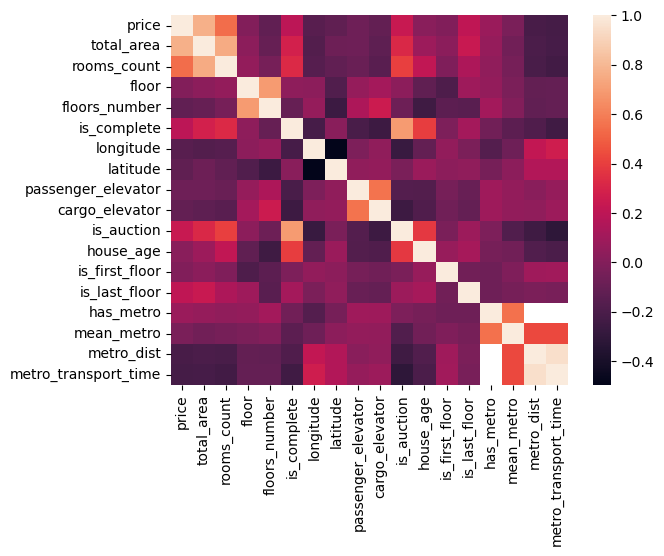

In [2194]:
sns.heatmap(df.corr())

In [2195]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Количество пропусков', 'Процент пропусков'])
missing_data

,Количество пропусков,Процент пропусков
balcony,10215,0.782040
build_date,8830,0.676007
decoration,6121,0.468611
completion_year,5917,0.452993
living_area,4465,0.341831
kitchen_area,4115,0.315036
cargo_elevator,2825,0.216276
is_apartments,2011,0.153958
passenger_elevator,1626,0.124483
house_age,1458,0.111621


In [2196]:
df.dtypes

region                   object
address                  object
price                     int64
total_area              float64
kitchen_area             object
living_area              object
rooms_count             float64
floor                     int64
floors_number             int64
build_date               object
is_complete             float64
completion_year          object
house_material           object
parking                  object
decoration               object
balcony                  object
longitude               float64
latitude                float64
passenger_elevator      float64
cargo_elevator          float64
metro                    object
metro_distance           object
metro_transport          object
district                 object
is_apartments            object
is_auction                int64
house_age               float64
is_first_floor            int64
is_last_floor             int64
has_metro                 int64
mean_metro              float64
metro_di

In [2197]:
target = ['price']

num_f = ['total_area',
         'floor',
         'floors_number',
         'house_age',
         'living_area',
         'kitchen_area',
         'longitude',
         'latitude',
         'mean_metro',
         'metro_dist',
         'metro_transport_time',
        ]

cat_f = ['region',
#          'decoration',
         'rooms_count',
         'is_complete',
         'house_material',
         'parking',
         'passenger_elevator',
#          'cargo_elevator',
         'is_apartments',
         'is_auction',
         'is_first_floor',
         'is_last_floor',
         'has_metro',
]

df = df[target+num_f+cat_f].copy()
num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')

for f in num_f:
    df[f] = StandardScaler().fit_transform(pd.DataFrame(num_imp.fit_transform(df[[f]])))

for f in cat_f:
    df[f] = OrdinalEncoder().fit_transform(pd.DataFrame(cat_imp.fit_transform(df[[f]])))


In [2198]:
df.head()

,price,total_area,floor,floors_number,house_age,living_area,kitchen_area,longitude,latitude,mean_metro,metro_dist,metro_transport_time,region,decoration,rooms_count,is_complete,house_material,parking,passenger_elevator,cargo_elevator,is_apartments,is_auction,is_first_floor,is_last_floor,has_metro
0,158220000,0.060627,-0.492339,-0.709842,-0.305137,-0.228929,-0.130737,-0.338996,-0.592841,1.418496,-0.699435,-0.827255,2.0,2.0,1.0,1.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,85974000,-0.263733,-0.045258,-0.709842,-0.259087,-0.228929,0.744568,-0.338115,-0.574955,0.045762,-0.891661,-0.827255,2.0,0.0,1.0,1.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,156750000,0.031486,-0.715880,-0.303195,-0.351186,-0.095500,-0.044169,-0.336330,-0.592716,-0.411815,-0.507209,-0.337212,2.0,2.0,1.0,0.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,52569000,-0.422112,0.066513,-0.059207,-0.351186,-0.289842,-0.130737,-0.339802,-0.606310,2.181126,-0.592642,-0.827255,2.0,2.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,99000000,0.092303,-0.380569,-0.465854,-0.351186,0.032127,-0.188450,-0.339867,-0.600510,-0.030501,-0.603322,-0.500560,2.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0


In [2199]:
df.shape

(13062, 25)

In [2200]:
from catboost import CatBoostRegressor

def modeling(data):

    X = data.copy().drop(['price'], axis=1)
    y = data['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    cat = CatBoostRegressor(silent=True, eval_metric='RMSE').fit(X_train, y_train)

    y_pred = cat.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

## Разбиение на кластеры по цене

In [2201]:
df.price.quantile(0.25), df.price.quantile(0.5)

(8962728.5, 19742000.0)

In [2206]:
df[(df['price']>150_000_000) & (df['price']<200_000_000)].shape

(383, 25)

In [2203]:
clusters = {
    '(0; 5)': df[df['price']<5_000_000],
    '(5; 10)': df[(df['price']>5_000_000) & (df['price']<10_000_000)],
    '(10; 20)': df[(df['price']>10_000_000) & (df['price']<20_000_000)],
    '(20; 30)': df[(df['price']>20_000_000) & (df['price']<30_000_000)],
    '(30; 60)': df[(df['price']>30_000_000) & (df['price']<60_000_000)],
    '(60;100)': df[(df['price']>60_000_000) & (df['price']<100_000_000)],
    '(100;150)': df[(df['price']>100_000_000) & (df['price']<150_000_000)],
}

for c, data in clusters.items():
    model = modeling(data)
    print(f'Price cluster: {c} with RMSE={model[0]:.2f}, R2={model[1]:.2f}')

Price cluster: (0; 10) with RMSE=707563.27, R2=0.85
Price cluster: (10; 20) with RMSE=1066376.17, R2=0.87
Price cluster: (20; 30) with RMSE=826646.31, R2=0.93
Price cluster: (30; 60) with RMSE=1161878.89, R2=0.98
Price cluster: (60;100) with RMSE=503979.99, R2=1.00
Price cluster: (100;inf) with RMSE=5234269.62, R2=1.00


In [2204]:
clusters_q = {
    '10%': df[df['price']<df.price.quantile(0.1)],
    '(10%;25%)': df[(df['price']>df.price.quantile(0.1)) & (df['price']<df.price.quantile(0.25))],
    '(25%; 50%)': df[(df['price']>df.price.quantile(0.25)) & (df['price']<df.price.quantile(0.5))],
    '(50%; 75%)': df[(df['price']>df.price.quantile(0.5)) & (df['price']<df.price.quantile(0.75))],
    '(75%;90%)': df[(df['price']>df.price.quantile(0.75)) & (df['price']<df.price.quantile(0.9))],
    '(90%)': df[(df['price']>df.price.quantile(0.9))],
}

for c, data in clusters_q.items():
    model = modeling(data)
    print(f'Price cluster: {c} with RMSE={model[0]:.2f}, R2={model[1]:.2f}')

Price cluster: 10% with RMSE=496581.35, R2=0.54
Price cluster: (10%;25%) with RMSE=513745.69, R2=0.66
Price cluster: (25%; 50%) with RMSE=1017569.22, R2=0.90
Price cluster: (50%; 75%) with RMSE=1222081.09, R2=0.98
Price cluster: (75%;90%) with RMSE=1875790.91, R2=1.00
Price cluster: (90%) with RMSE=3879672.59, R2=1.00


## Моделирование

(5620623.484884297, 0.9983330764451527)

In [2077]:
# cvscore = cross_val_score(CatBoostRegressor(), X_train, y_train, scoring='neg_root_mean_squared_error', verbose=4)
# cvscore*(-1)

Learning rate set to 0.057264
0:	learn: 130668990.2179137	total: 1.98ms	remaining: 1.98s
1:	learn: 125448915.3274100	total: 3.43ms	remaining: 1.71s
2:	learn: 120502318.2725912	total: 4.84ms	remaining: 1.61s
3:	learn: 115729966.6083542	total: 6.21ms	remaining: 1.54s
4:	learn: 111297050.6492649	total: 7.7ms	remaining: 1.53s
5:	learn: 106859347.3115823	total: 8.99ms	remaining: 1.49s
6:	learn: 102813159.9196081	total: 10.3ms	remaining: 1.46s
7:	learn: 99147422.2121977	total: 11.6ms	remaining: 1.44s
8:	learn: 95729292.1620187	total: 13.3ms	remaining: 1.46s
9:	learn: 92330258.2954355	total: 14.8ms	remaining: 1.46s
10:	learn: 89233623.0838092	total: 16ms	remaining: 1.44s
11:	learn: 86165369.0503104	total: 17.2ms	remaining: 1.42s
12:	learn: 83084297.3418804	total: 18.5ms	remaining: 1.4s
13:	learn: 80200510.9487695	total: 19.6ms	remaining: 1.38s
14:	learn: 77558481.1860870	total: 20.9ms	remaining: 1.37s
15:	learn: 75290417.2557174	total: 22.2ms	remaining: 1.36s
16:	learn: 72927063.5008813	total

146:	learn: 22010545.1286340	total: 181ms	remaining: 1.05s
147:	learn: 21918226.1226369	total: 182ms	remaining: 1.05s
148:	learn: 21806375.7520430	total: 183ms	remaining: 1.05s
149:	learn: 21742867.9471589	total: 184ms	remaining: 1.04s
150:	learn: 21711962.7796029	total: 186ms	remaining: 1.04s
151:	learn: 21578119.9376291	total: 187ms	remaining: 1.04s
152:	learn: 21489749.2796097	total: 188ms	remaining: 1.04s
153:	learn: 21415138.4157198	total: 190ms	remaining: 1.04s
154:	learn: 21335585.1252940	total: 191ms	remaining: 1.04s
155:	learn: 21225665.9499210	total: 193ms	remaining: 1.04s
156:	learn: 21163414.5605895	total: 195ms	remaining: 1.04s
157:	learn: 21106168.8805822	total: 196ms	remaining: 1.04s
158:	learn: 21015403.8544053	total: 197ms	remaining: 1.04s
159:	learn: 20984812.9400523	total: 199ms	remaining: 1.04s
160:	learn: 20956753.0137593	total: 200ms	remaining: 1.04s
161:	learn: 20916892.4738876	total: 201ms	remaining: 1.04s
162:	learn: 20879580.4120910	total: 202ms	remaining: 1.0

300:	learn: 13828269.0572236	total: 377ms	remaining: 875ms
301:	learn: 13798093.7436534	total: 378ms	remaining: 875ms
302:	learn: 13768423.8872955	total: 380ms	remaining: 873ms
303:	learn: 13741037.6823318	total: 381ms	remaining: 872ms
304:	learn: 13710073.8348917	total: 382ms	remaining: 871ms
305:	learn: 13684636.5742616	total: 383ms	remaining: 869ms
306:	learn: 13635051.0304347	total: 384ms	remaining: 868ms
307:	learn: 13608011.0197867	total: 386ms	remaining: 866ms
308:	learn: 13582891.5507602	total: 387ms	remaining: 865ms
309:	learn: 13559355.3216303	total: 388ms	remaining: 864ms
310:	learn: 13538825.5551275	total: 389ms	remaining: 862ms
311:	learn: 13523147.7761291	total: 390ms	remaining: 861ms
312:	learn: 13491285.3989531	total: 392ms	remaining: 860ms
313:	learn: 13469605.4434934	total: 393ms	remaining: 858ms
314:	learn: 13431905.5338171	total: 394ms	remaining: 857ms
315:	learn: 13399967.5974995	total: 395ms	remaining: 856ms
316:	learn: 13379115.6803554	total: 397ms	remaining: 855

462:	learn: 10252547.8559743	total: 572ms	remaining: 664ms
463:	learn: 10235168.5684772	total: 573ms	remaining: 662ms
464:	learn: 10206136.4646156	total: 575ms	remaining: 661ms
465:	learn: 10191859.6413063	total: 576ms	remaining: 660ms
466:	learn: 10179265.9929467	total: 577ms	remaining: 658ms
467:	learn: 10164508.5739380	total: 578ms	remaining: 657ms
468:	learn: 10144007.3317597	total: 579ms	remaining: 656ms
469:	learn: 10126946.6809031	total: 580ms	remaining: 655ms
470:	learn: 10096275.2356399	total: 582ms	remaining: 654ms
471:	learn: 10079366.1666121	total: 583ms	remaining: 652ms
472:	learn: 10072607.6174554	total: 584ms	remaining: 651ms
473:	learn: 10050861.6915597	total: 586ms	remaining: 650ms
474:	learn: 10027569.3531493	total: 587ms	remaining: 649ms
475:	learn: 10012615.1061770	total: 588ms	remaining: 647ms
476:	learn: 9999371.4323747	total: 589ms	remaining: 646ms
477:	learn: 9984608.2957494	total: 590ms	remaining: 645ms
478:	learn: 9955414.3039201	total: 592ms	remaining: 643ms


622:	learn: 7813103.2863739	total: 769ms	remaining: 465ms
623:	learn: 7803378.2097220	total: 770ms	remaining: 464ms
624:	learn: 7787391.5215703	total: 771ms	remaining: 462ms
625:	learn: 7779163.8388768	total: 772ms	remaining: 461ms
626:	learn: 7772375.4212873	total: 773ms	remaining: 460ms
627:	learn: 7759909.8220435	total: 775ms	remaining: 459ms
628:	learn: 7747963.2784717	total: 776ms	remaining: 458ms
629:	learn: 7737466.1293178	total: 777ms	remaining: 456ms
630:	learn: 7726057.5905514	total: 778ms	remaining: 455ms
631:	learn: 7708140.0393740	total: 779ms	remaining: 454ms
632:	learn: 7699087.3659385	total: 780ms	remaining: 452ms
633:	learn: 7680539.5016543	total: 782ms	remaining: 451ms
634:	learn: 7669660.1729558	total: 783ms	remaining: 450ms
635:	learn: 7655479.6609601	total: 784ms	remaining: 449ms
636:	learn: 7639335.4952875	total: 786ms	remaining: 448ms
637:	learn: 7627951.2785745	total: 788ms	remaining: 447ms
638:	learn: 7621807.7828080	total: 789ms	remaining: 446ms
639:	learn: 76

782:	learn: 6226958.9284716	total: 965ms	remaining: 267ms
783:	learn: 6218855.3563358	total: 966ms	remaining: 266ms
784:	learn: 6212604.0630168	total: 968ms	remaining: 265ms
785:	learn: 6203368.5797534	total: 969ms	remaining: 264ms
786:	learn: 6199374.7025368	total: 970ms	remaining: 263ms
787:	learn: 6193793.3107255	total: 972ms	remaining: 261ms
788:	learn: 6187723.5765047	total: 973ms	remaining: 260ms
789:	learn: 6184413.4559821	total: 974ms	remaining: 259ms
790:	learn: 6175967.7277582	total: 975ms	remaining: 258ms
791:	learn: 6168267.3020344	total: 977ms	remaining: 256ms
792:	learn: 6163880.6634979	total: 978ms	remaining: 255ms
793:	learn: 6160161.2934568	total: 980ms	remaining: 254ms
794:	learn: 6152698.7148258	total: 981ms	remaining: 253ms
795:	learn: 6145087.6958469	total: 982ms	remaining: 252ms
796:	learn: 6139198.5004838	total: 984ms	remaining: 251ms
797:	learn: 6134824.1675010	total: 985ms	remaining: 249ms
798:	learn: 6121292.4715680	total: 986ms	remaining: 248ms
799:	learn: 61

929:	learn: 5288663.4501814	total: 1.16s	remaining: 87.3ms
930:	learn: 5280247.5812006	total: 1.16s	remaining: 86.1ms
931:	learn: 5273018.5065662	total: 1.16s	remaining: 84.9ms
932:	learn: 5270306.5570544	total: 1.16s	remaining: 83.6ms
933:	learn: 5266865.1714892	total: 1.17s	remaining: 82.4ms
934:	learn: 5263163.4585039	total: 1.17s	remaining: 81.1ms
935:	learn: 5253858.6459255	total: 1.17s	remaining: 79.9ms
936:	learn: 5249406.1850477	total: 1.17s	remaining: 78.6ms
937:	learn: 5245069.4629104	total: 1.17s	remaining: 77.4ms
938:	learn: 5235967.2907977	total: 1.17s	remaining: 76.1ms
939:	learn: 5228584.5072931	total: 1.17s	remaining: 74.9ms
940:	learn: 5222174.5026150	total: 1.17s	remaining: 73.6ms
941:	learn: 5214875.9015077	total: 1.18s	remaining: 72.4ms
942:	learn: 5212966.8777256	total: 1.18s	remaining: 71.1ms
943:	learn: 5211276.4960653	total: 1.18s	remaining: 69.9ms
944:	learn: 5207453.5530508	total: 1.18s	remaining: 68.6ms
945:	learn: 5203269.2557629	total: 1.18s	remaining: 67.4

74:	learn: 30375625.5309921	total: 95.6ms	remaining: 1.18s
75:	learn: 30106223.7896590	total: 96.8ms	remaining: 1.18s
76:	learn: 29915749.3828224	total: 98.1ms	remaining: 1.18s
77:	learn: 29743690.2277908	total: 99.4ms	remaining: 1.18s
78:	learn: 29510027.1378532	total: 101ms	remaining: 1.18s
79:	learn: 29355109.2705183	total: 103ms	remaining: 1.18s
80:	learn: 29236586.8913952	total: 104ms	remaining: 1.18s
81:	learn: 29123114.7385103	total: 105ms	remaining: 1.18s
82:	learn: 28849929.9556368	total: 106ms	remaining: 1.17s
83:	learn: 28667513.8416465	total: 108ms	remaining: 1.17s
84:	learn: 28511229.4326889	total: 109ms	remaining: 1.17s
85:	learn: 28419154.8323475	total: 110ms	remaining: 1.17s
86:	learn: 28285341.8643239	total: 111ms	remaining: 1.17s
87:	learn: 28110804.4574208	total: 112ms	remaining: 1.16s
88:	learn: 27981737.4300503	total: 114ms	remaining: 1.16s
89:	learn: 27858201.9497483	total: 115ms	remaining: 1.16s
90:	learn: 27621994.9285047	total: 116ms	remaining: 1.16s
91:	learn:

231:	learn: 16525661.2839748	total: 292ms	remaining: 967ms
232:	learn: 16486624.1632535	total: 293ms	remaining: 965ms
233:	learn: 16439543.8446939	total: 294ms	remaining: 964ms
234:	learn: 16371498.9227609	total: 296ms	remaining: 962ms
235:	learn: 16315061.6317832	total: 297ms	remaining: 960ms
236:	learn: 16278988.2599142	total: 298ms	remaining: 959ms
237:	learn: 16245354.0440400	total: 299ms	remaining: 957ms
238:	learn: 16200900.9105268	total: 300ms	remaining: 956ms
239:	learn: 16143497.2770564	total: 301ms	remaining: 954ms
240:	learn: 16115384.2002788	total: 303ms	remaining: 954ms
241:	learn: 16080546.1146712	total: 304ms	remaining: 952ms
242:	learn: 16037096.4117529	total: 305ms	remaining: 951ms
243:	learn: 15998617.6692118	total: 307ms	remaining: 950ms
244:	learn: 15926039.2199141	total: 308ms	remaining: 950ms
245:	learn: 15878969.3663538	total: 310ms	remaining: 949ms
246:	learn: 15837230.3386071	total: 311ms	remaining: 948ms
247:	learn: 15752559.5505774	total: 312ms	remaining: 946

387:	learn: 11415716.2570201	total: 488ms	remaining: 770ms
388:	learn: 11391551.8571191	total: 490ms	remaining: 769ms
389:	learn: 11371145.1233416	total: 491ms	remaining: 768ms
390:	learn: 11338889.7539764	total: 492ms	remaining: 766ms
391:	learn: 11319502.2922708	total: 493ms	remaining: 765ms
392:	learn: 11299263.3143735	total: 494ms	remaining: 764ms
393:	learn: 11282322.0031659	total: 496ms	remaining: 762ms
394:	learn: 11268978.5088789	total: 497ms	remaining: 762ms
395:	learn: 11262635.3675248	total: 498ms	remaining: 760ms
396:	learn: 11238904.0781924	total: 500ms	remaining: 759ms
397:	learn: 11220928.1002388	total: 501ms	remaining: 758ms
398:	learn: 11191040.5502149	total: 503ms	remaining: 757ms
399:	learn: 11176208.8610371	total: 504ms	remaining: 756ms
400:	learn: 11148796.6559349	total: 505ms	remaining: 755ms
401:	learn: 11126074.9467115	total: 506ms	remaining: 753ms
402:	learn: 11103855.5536487	total: 507ms	remaining: 752ms
403:	learn: 11093053.8851633	total: 508ms	remaining: 750

551:	learn: 8511069.6950402	total: 685ms	remaining: 556ms
552:	learn: 8503739.5667999	total: 686ms	remaining: 555ms
553:	learn: 8490614.4632506	total: 687ms	remaining: 553ms
554:	learn: 8468090.1507544	total: 688ms	remaining: 552ms
555:	learn: 8456996.2703586	total: 689ms	remaining: 551ms
556:	learn: 8440117.7153856	total: 691ms	remaining: 549ms
557:	learn: 8424220.5047622	total: 692ms	remaining: 548ms
558:	learn: 8413441.8266575	total: 693ms	remaining: 547ms
559:	learn: 8392462.3379099	total: 694ms	remaining: 546ms
560:	learn: 8387262.4037277	total: 696ms	remaining: 545ms
561:	learn: 8374567.9658794	total: 698ms	remaining: 544ms
562:	learn: 8362226.8504341	total: 699ms	remaining: 543ms
563:	learn: 8349881.7635296	total: 700ms	remaining: 541ms
564:	learn: 8334199.0993665	total: 701ms	remaining: 540ms
565:	learn: 8315134.8871108	total: 702ms	remaining: 539ms
566:	learn: 8293248.9389021	total: 703ms	remaining: 537ms
567:	learn: 8262526.4430438	total: 705ms	remaining: 536ms
568:	learn: 82

715:	learn: 6747622.6738588	total: 879ms	remaining: 349ms
716:	learn: 6738268.5259044	total: 882ms	remaining: 348ms
717:	learn: 6728550.5246878	total: 892ms	remaining: 350ms
718:	learn: 6722325.4815143	total: 894ms	remaining: 349ms
719:	learn: 6717796.4194001	total: 896ms	remaining: 348ms
720:	learn: 6709094.1573155	total: 898ms	remaining: 347ms
721:	learn: 6700066.1833700	total: 899ms	remaining: 346ms
722:	learn: 6694608.1819260	total: 901ms	remaining: 345ms
723:	learn: 6692172.8000438	total: 902ms	remaining: 344ms
724:	learn: 6680675.7831393	total: 903ms	remaining: 343ms
725:	learn: 6669550.5745759	total: 905ms	remaining: 341ms
726:	learn: 6659937.4379571	total: 906ms	remaining: 340ms
727:	learn: 6655581.9965685	total: 907ms	remaining: 339ms
728:	learn: 6642289.1029507	total: 909ms	remaining: 338ms
729:	learn: 6634767.6762159	total: 910ms	remaining: 337ms
730:	learn: 6627969.6431904	total: 911ms	remaining: 335ms
731:	learn: 6617848.8330503	total: 912ms	remaining: 334ms
732:	learn: 66

863:	learn: 5694298.2364029	total: 1.07s	remaining: 169ms
864:	learn: 5688467.0548164	total: 1.08s	remaining: 168ms
865:	learn: 5684791.2857949	total: 1.08s	remaining: 167ms
866:	learn: 5682232.9419979	total: 1.08s	remaining: 165ms
867:	learn: 5678789.9809593	total: 1.08s	remaining: 164ms
868:	learn: 5665636.7651434	total: 1.08s	remaining: 163ms
869:	learn: 5660997.6958051	total: 1.08s	remaining: 162ms
870:	learn: 5654598.5908246	total: 1.08s	remaining: 160ms
871:	learn: 5651000.6696040	total: 1.08s	remaining: 159ms
872:	learn: 5634943.5561387	total: 1.09s	remaining: 158ms
873:	learn: 5630812.2940414	total: 1.09s	remaining: 157ms
874:	learn: 5626521.1069492	total: 1.09s	remaining: 155ms
875:	learn: 5611029.7724446	total: 1.09s	remaining: 154ms
876:	learn: 5608976.5981968	total: 1.09s	remaining: 153ms
877:	learn: 5603539.5274802	total: 1.09s	remaining: 152ms
878:	learn: 5601376.5925080	total: 1.09s	remaining: 150ms
879:	learn: 5599248.9646949	total: 1.09s	remaining: 149ms
880:	learn: 55

16:	learn: 71538148.4759340	total: 19.1ms	remaining: 1.1s
17:	learn: 69408850.8050072	total: 20.3ms	remaining: 1.1s
18:	learn: 67447793.4108397	total: 21.4ms	remaining: 1.1s
19:	learn: 65514177.3451184	total: 23.2ms	remaining: 1.13s
20:	learn: 63607685.6350967	total: 24.4ms	remaining: 1.14s
21:	learn: 61907136.4771696	total: 25.6ms	remaining: 1.14s
22:	learn: 60269883.1905619	total: 26.7ms	remaining: 1.13s
23:	learn: 58921009.3562917	total: 27.9ms	remaining: 1.14s
24:	learn: 57425864.1713376	total: 29.3ms	remaining: 1.14s
25:	learn: 55953475.4754508	total: 30.7ms	remaining: 1.15s
26:	learn: 54735463.4765242	total: 32ms	remaining: 1.15s
27:	learn: 53479074.7498235	total: 33.1ms	remaining: 1.15s
28:	learn: 52307350.1761096	total: 34.3ms	remaining: 1.15s
29:	learn: 51139158.3802322	total: 36.1ms	remaining: 1.17s
30:	learn: 49974863.6719915	total: 37.2ms	remaining: 1.16s
31:	learn: 48901852.8216563	total: 38.3ms	remaining: 1.16s
32:	learn: 48027804.5469716	total: 39.4ms	remaining: 1.16s
33

176:	learn: 19527967.3054316	total: 215ms	remaining: 1000ms
177:	learn: 19403621.9678152	total: 216ms	remaining: 999ms
178:	learn: 19326044.3703284	total: 217ms	remaining: 997ms
179:	learn: 19257423.1480521	total: 218ms	remaining: 995ms
180:	learn: 19124945.8194764	total: 220ms	remaining: 994ms
181:	learn: 19079700.7046101	total: 221ms	remaining: 992ms
182:	learn: 18997343.7023488	total: 222ms	remaining: 991ms
183:	learn: 18946024.3246887	total: 223ms	remaining: 989ms
184:	learn: 18859649.6005976	total: 224ms	remaining: 988ms
185:	learn: 18820061.6717585	total: 226ms	remaining: 987ms
186:	learn: 18774959.5211053	total: 228ms	remaining: 990ms
187:	learn: 18734817.8583079	total: 229ms	remaining: 988ms
188:	learn: 18686183.6599854	total: 230ms	remaining: 987ms
189:	learn: 18624016.6821407	total: 231ms	remaining: 986ms
190:	learn: 18558890.3336892	total: 232ms	remaining: 984ms
191:	learn: 18510056.1786609	total: 234ms	remaining: 983ms
192:	learn: 18470382.6939963	total: 235ms	remaining: 98

337:	learn: 12505088.5945712	total: 411ms	remaining: 806ms
338:	learn: 12450300.7064276	total: 413ms	remaining: 805ms
339:	learn: 12428670.3261697	total: 414ms	remaining: 803ms
340:	learn: 12409788.9566672	total: 415ms	remaining: 801ms
341:	learn: 12376955.6834027	total: 416ms	remaining: 800ms
342:	learn: 12355601.9775185	total: 417ms	remaining: 799ms
343:	learn: 12332418.3442210	total: 418ms	remaining: 798ms
344:	learn: 12303662.1034343	total: 419ms	remaining: 796ms
345:	learn: 12286370.8615246	total: 421ms	remaining: 796ms
346:	learn: 12264866.0093857	total: 422ms	remaining: 795ms
347:	learn: 12243694.7338857	total: 423ms	remaining: 793ms
348:	learn: 12218491.0352112	total: 425ms	remaining: 792ms
349:	learn: 12197297.0300316	total: 426ms	remaining: 791ms
350:	learn: 12162980.8683129	total: 427ms	remaining: 790ms
351:	learn: 12140378.5212899	total: 428ms	remaining: 789ms
352:	learn: 12112659.3353097	total: 430ms	remaining: 788ms
353:	learn: 12086348.8753889	total: 431ms	remaining: 787

497:	learn: 9406569.7173537	total: 608ms	remaining: 613ms
498:	learn: 9378168.0421857	total: 609ms	remaining: 612ms
499:	learn: 9361015.3865636	total: 611ms	remaining: 611ms
500:	learn: 9351285.3135021	total: 612ms	remaining: 610ms
501:	learn: 9343696.1643138	total: 613ms	remaining: 609ms
502:	learn: 9324714.1542952	total: 615ms	remaining: 607ms
503:	learn: 9305712.6186720	total: 616ms	remaining: 606ms
504:	learn: 9298629.8498366	total: 617ms	remaining: 605ms
505:	learn: 9268475.0028048	total: 618ms	remaining: 603ms
506:	learn: 9253461.6728469	total: 619ms	remaining: 602ms
507:	learn: 9238294.8132795	total: 621ms	remaining: 601ms
508:	learn: 9229137.6694256	total: 622ms	remaining: 600ms
509:	learn: 9206247.0693475	total: 624ms	remaining: 599ms
510:	learn: 9199883.4677905	total: 626ms	remaining: 599ms
511:	learn: 9173405.5464356	total: 627ms	remaining: 598ms
512:	learn: 9163918.7423445	total: 628ms	remaining: 596ms
513:	learn: 9144410.0139548	total: 629ms	remaining: 595ms
514:	learn: 91

649:	learn: 7382393.4810404	total: 803ms	remaining: 432ms
650:	learn: 7376411.2538661	total: 804ms	remaining: 431ms
651:	learn: 7364123.1345230	total: 805ms	remaining: 430ms
652:	learn: 7344463.9890368	total: 806ms	remaining: 428ms
653:	learn: 7328190.9045880	total: 807ms	remaining: 427ms
654:	learn: 7323146.3266287	total: 809ms	remaining: 426ms
655:	learn: 7310991.3430011	total: 810ms	remaining: 425ms
656:	learn: 7298670.9768372	total: 812ms	remaining: 424ms
657:	learn: 7285116.6718808	total: 813ms	remaining: 422ms
658:	learn: 7278716.3408047	total: 815ms	remaining: 421ms
659:	learn: 7258444.9662668	total: 816ms	remaining: 420ms
660:	learn: 7251568.7542973	total: 817ms	remaining: 419ms
661:	learn: 7241051.9899754	total: 818ms	remaining: 418ms
662:	learn: 7231280.9975180	total: 820ms	remaining: 417ms
663:	learn: 7214359.2775952	total: 822ms	remaining: 416ms
664:	learn: 7205535.0757284	total: 823ms	remaining: 415ms
665:	learn: 7188666.0731825	total: 824ms	remaining: 413ms
666:	learn: 71

810:	learn: 6134116.3567610	total: 999ms	remaining: 233ms
811:	learn: 6127924.1834404	total: 1000ms	remaining: 231ms
812:	learn: 6125167.9659226	total: 1s	remaining: 230ms
813:	learn: 6116430.0222760	total: 1s	remaining: 229ms
814:	learn: 6113590.7699380	total: 1s	remaining: 228ms
815:	learn: 6100096.7801866	total: 1s	remaining: 227ms
816:	learn: 6092431.4014960	total: 1s	remaining: 225ms
817:	learn: 6079608.9221063	total: 1.01s	remaining: 224ms
818:	learn: 6068696.0980363	total: 1.01s	remaining: 223ms
819:	learn: 6057673.5930885	total: 1.01s	remaining: 222ms
820:	learn: 6054446.3197735	total: 1.01s	remaining: 220ms
821:	learn: 6045641.8368616	total: 1.01s	remaining: 219ms
822:	learn: 6042832.5697779	total: 1.01s	remaining: 218ms
823:	learn: 6040699.0574833	total: 1.01s	remaining: 217ms
824:	learn: 6038266.9969118	total: 1.01s	remaining: 215ms
825:	learn: 6026939.2360548	total: 1.02s	remaining: 214ms
826:	learn: 6024231.0470028	total: 1.02s	remaining: 213ms
827:	learn: 6005248.9911103	

967:	learn: 5174931.9811121	total: 1.2s	remaining: 39.5ms
968:	learn: 5168707.2783640	total: 1.2s	remaining: 38.3ms
969:	learn: 5167009.1826800	total: 1.2s	remaining: 37ms
970:	learn: 5163453.9673060	total: 1.2s	remaining: 35.8ms
971:	learn: 5156121.2459206	total: 1.2s	remaining: 34.6ms
972:	learn: 5153171.2525368	total: 1.2s	remaining: 33.4ms
973:	learn: 5146461.8147061	total: 1.2s	remaining: 32.1ms
974:	learn: 5143768.3158896	total: 1.2s	remaining: 30.9ms
975:	learn: 5138608.9137389	total: 1.21s	remaining: 29.7ms
976:	learn: 5135815.0274699	total: 1.21s	remaining: 28.4ms
977:	learn: 5125108.2713334	total: 1.21s	remaining: 27.2ms
978:	learn: 5120597.3686840	total: 1.21s	remaining: 25.9ms
979:	learn: 5116304.8932663	total: 1.21s	remaining: 24.7ms
980:	learn: 5112906.5304879	total: 1.21s	remaining: 23.5ms
981:	learn: 5109580.9329058	total: 1.21s	remaining: 22.2ms
982:	learn: 5096841.8027428	total: 1.21s	remaining: 21ms
983:	learn: 5094170.9180715	total: 1.22s	remaining: 19.8ms
984:	lear

118:	learn: 24389697.0410659	total: 146ms	remaining: 1.08s
119:	learn: 24307934.0542251	total: 147ms	remaining: 1.08s
120:	learn: 24148522.1000304	total: 148ms	remaining: 1.07s
121:	learn: 24066386.7824950	total: 149ms	remaining: 1.07s
122:	learn: 23963561.8212123	total: 151ms	remaining: 1.07s
123:	learn: 23844478.3651898	total: 152ms	remaining: 1.07s
124:	learn: 23728794.0631051	total: 153ms	remaining: 1.07s
125:	learn: 23670650.4539470	total: 155ms	remaining: 1.07s
126:	learn: 23604734.1614230	total: 156ms	remaining: 1.07s
127:	learn: 23554448.9998295	total: 157ms	remaining: 1.07s
128:	learn: 23372818.3147766	total: 158ms	remaining: 1.07s
129:	learn: 23232519.0367051	total: 160ms	remaining: 1.07s
130:	learn: 23110852.0847706	total: 162ms	remaining: 1.07s
131:	learn: 23028168.2668711	total: 163ms	remaining: 1.07s
132:	learn: 22962775.7853586	total: 164ms	remaining: 1.07s
133:	learn: 22876003.0761494	total: 165ms	remaining: 1.07s
134:	learn: 22831957.7380663	total: 166ms	remaining: 1.0

277:	learn: 15034953.9940728	total: 341ms	remaining: 886ms
278:	learn: 15001751.1132482	total: 342ms	remaining: 884ms
279:	learn: 14949050.4379097	total: 343ms	remaining: 883ms
280:	learn: 14934546.0423040	total: 345ms	remaining: 882ms
281:	learn: 14893317.9116361	total: 346ms	remaining: 881ms
282:	learn: 14881516.8065072	total: 347ms	remaining: 879ms
283:	learn: 14858957.7766665	total: 348ms	remaining: 878ms
284:	learn: 14824317.9410387	total: 349ms	remaining: 877ms
285:	learn: 14775338.6518037	total: 351ms	remaining: 876ms
286:	learn: 14728873.8046084	total: 352ms	remaining: 874ms
287:	learn: 14703340.9510919	total: 353ms	remaining: 873ms
288:	learn: 14688068.8631293	total: 354ms	remaining: 872ms
289:	learn: 14654784.7984808	total: 355ms	remaining: 870ms
290:	learn: 14640879.1732951	total: 357ms	remaining: 869ms
291:	learn: 14596373.4243908	total: 358ms	remaining: 868ms
292:	learn: 14551142.9113032	total: 359ms	remaining: 867ms
293:	learn: 14518720.2065313	total: 360ms	remaining: 865

438:	learn: 10692617.4157355	total: 537ms	remaining: 686ms
439:	learn: 10680874.8049575	total: 538ms	remaining: 685ms
440:	learn: 10673017.5192485	total: 539ms	remaining: 683ms
441:	learn: 10647158.6738460	total: 540ms	remaining: 682ms
442:	learn: 10617330.9214962	total: 542ms	remaining: 681ms
443:	learn: 10586278.6614607	total: 543ms	remaining: 680ms
444:	learn: 10543862.9871677	total: 544ms	remaining: 679ms
445:	learn: 10534673.0737236	total: 546ms	remaining: 678ms
446:	learn: 10523638.0263144	total: 547ms	remaining: 676ms
447:	learn: 10508748.7069754	total: 548ms	remaining: 675ms
448:	learn: 10497119.5219454	total: 549ms	remaining: 674ms
449:	learn: 10476069.5818332	total: 550ms	remaining: 673ms
450:	learn: 10467815.9806475	total: 551ms	remaining: 671ms
451:	learn: 10452891.0625980	total: 553ms	remaining: 670ms
452:	learn: 10444850.1473260	total: 554ms	remaining: 669ms
453:	learn: 10422344.6605621	total: 555ms	remaining: 668ms
454:	learn: 10400868.8142457	total: 556ms	remaining: 666

600:	learn: 8202107.2697225	total: 732ms	remaining: 486ms
601:	learn: 8183445.3192842	total: 733ms	remaining: 484ms
602:	learn: 8174421.2553145	total: 734ms	remaining: 483ms
603:	learn: 8149988.2404653	total: 735ms	remaining: 482ms
604:	learn: 8138313.7471959	total: 736ms	remaining: 481ms
605:	learn: 8124486.7187951	total: 738ms	remaining: 480ms
606:	learn: 8114654.9472740	total: 739ms	remaining: 478ms
607:	learn: 8108763.1523209	total: 741ms	remaining: 478ms
608:	learn: 8102338.5374726	total: 742ms	remaining: 476ms
609:	learn: 8096230.7835038	total: 743ms	remaining: 475ms
610:	learn: 8086900.4628631	total: 744ms	remaining: 474ms
611:	learn: 8073886.1607572	total: 746ms	remaining: 473ms
612:	learn: 8061577.7387353	total: 747ms	remaining: 472ms
613:	learn: 8050389.4680964	total: 749ms	remaining: 471ms
614:	learn: 8040502.4132811	total: 750ms	remaining: 469ms
615:	learn: 8031270.6387043	total: 751ms	remaining: 468ms
616:	learn: 8020331.2588640	total: 752ms	remaining: 467ms
617:	learn: 80

765:	learn: 6585568.3482479	total: 928ms	remaining: 284ms
766:	learn: 6577899.8470076	total: 929ms	remaining: 282ms
767:	learn: 6563883.4320267	total: 930ms	remaining: 281ms
768:	learn: 6559029.5767792	total: 931ms	remaining: 280ms
769:	learn: 6545334.8757337	total: 932ms	remaining: 279ms
770:	learn: 6540061.2549413	total: 934ms	remaining: 278ms
771:	learn: 6537432.1110528	total: 935ms	remaining: 276ms
772:	learn: 6531970.0482159	total: 937ms	remaining: 275ms
773:	learn: 6524602.5945827	total: 938ms	remaining: 274ms
774:	learn: 6513450.8525937	total: 939ms	remaining: 273ms
775:	learn: 6498444.7859749	total: 940ms	remaining: 271ms
776:	learn: 6484450.5070335	total: 941ms	remaining: 270ms
777:	learn: 6479563.2933364	total: 944ms	remaining: 269ms
778:	learn: 6472296.7095014	total: 945ms	remaining: 268ms
779:	learn: 6471125.4468241	total: 946ms	remaining: 267ms
780:	learn: 6464843.2071660	total: 947ms	remaining: 266ms
781:	learn: 6454592.5080922	total: 949ms	remaining: 264ms
782:	learn: 64

926:	learn: 5482284.9577972	total: 1.12s	remaining: 88.1ms
927:	learn: 5476955.9844431	total: 1.12s	remaining: 86.9ms
928:	learn: 5472336.2249969	total: 1.12s	remaining: 85.7ms
929:	learn: 5463112.4741062	total: 1.12s	remaining: 84.5ms
930:	learn: 5460101.0090113	total: 1.12s	remaining: 83.2ms
931:	learn: 5449714.3449450	total: 1.12s	remaining: 82ms
932:	learn: 5438062.2572122	total: 1.13s	remaining: 80.9ms
933:	learn: 5433016.1686577	total: 1.13s	remaining: 79.7ms
934:	learn: 5425057.7498309	total: 1.13s	remaining: 78.5ms
935:	learn: 5422006.9980526	total: 1.13s	remaining: 77.3ms
936:	learn: 5415292.6639158	total: 1.13s	remaining: 76.2ms
937:	learn: 5411152.0203021	total: 1.13s	remaining: 75ms
938:	learn: 5406155.8744861	total: 1.14s	remaining: 73.8ms
939:	learn: 5394264.4125321	total: 1.14s	remaining: 72.6ms
940:	learn: 5386259.7450241	total: 1.14s	remaining: 71.4ms
941:	learn: 5380547.7723946	total: 1.14s	remaining: 70.2ms
942:	learn: 5372316.4178919	total: 1.14s	remaining: 69ms
943

73:	learn: 30901680.0367428	total: 92.9ms	remaining: 1.16s
74:	learn: 30646924.9752530	total: 94.3ms	remaining: 1.16s
75:	learn: 30438585.7194268	total: 95.5ms	remaining: 1.16s
76:	learn: 30259376.8034224	total: 96.8ms	remaining: 1.16s
77:	learn: 30071991.9436404	total: 98.1ms	remaining: 1.16s
78:	learn: 29860585.5143279	total: 99.4ms	remaining: 1.16s
79:	learn: 29657973.1875958	total: 101ms	remaining: 1.16s
80:	learn: 29537065.9669664	total: 102ms	remaining: 1.16s
81:	learn: 29335540.9466336	total: 103ms	remaining: 1.16s
82:	learn: 29188179.1793481	total: 105ms	remaining: 1.16s
83:	learn: 29061031.4418377	total: 106ms	remaining: 1.16s
84:	learn: 28946979.7999849	total: 107ms	remaining: 1.15s
85:	learn: 28844103.6011097	total: 108ms	remaining: 1.15s
86:	learn: 28609483.9920991	total: 110ms	remaining: 1.15s
87:	learn: 28423161.8035082	total: 111ms	remaining: 1.15s
88:	learn: 28313617.7826507	total: 112ms	remaining: 1.15s
89:	learn: 28209148.3467724	total: 114ms	remaining: 1.15s
90:	lear

230:	learn: 17007471.9959516	total: 289ms	remaining: 962ms
231:	learn: 16973016.5381492	total: 290ms	remaining: 962ms
232:	learn: 16945282.3237981	total: 292ms	remaining: 960ms
233:	learn: 16909466.5519230	total: 293ms	remaining: 959ms
234:	learn: 16830631.6620276	total: 294ms	remaining: 958ms
235:	learn: 16798252.9406209	total: 296ms	remaining: 957ms
236:	learn: 16731518.4067133	total: 297ms	remaining: 956ms
237:	learn: 16660995.0523989	total: 298ms	remaining: 955ms
238:	learn: 16576569.2054868	total: 300ms	remaining: 954ms
239:	learn: 16548612.4807728	total: 301ms	remaining: 952ms
240:	learn: 16521758.3341648	total: 302ms	remaining: 951ms
241:	learn: 16490270.6417078	total: 303ms	remaining: 949ms
242:	learn: 16433489.2212547	total: 304ms	remaining: 948ms
243:	learn: 16389429.3353289	total: 306ms	remaining: 947ms
244:	learn: 16360451.7859565	total: 307ms	remaining: 945ms
245:	learn: 16328627.1174716	total: 308ms	remaining: 944ms
246:	learn: 16270052.5306641	total: 309ms	remaining: 942

393:	learn: 11521499.6403128	total: 485ms	remaining: 747ms
394:	learn: 11501791.8738061	total: 487ms	remaining: 745ms
395:	learn: 11484063.2162629	total: 488ms	remaining: 744ms
396:	learn: 11430520.5853677	total: 489ms	remaining: 743ms
397:	learn: 11412324.8948430	total: 490ms	remaining: 741ms
398:	learn: 11379614.2184872	total: 491ms	remaining: 740ms
399:	learn: 11368307.8051770	total: 493ms	remaining: 739ms
400:	learn: 11335349.8041076	total: 494ms	remaining: 738ms
401:	learn: 11312614.7034965	total: 495ms	remaining: 737ms
402:	learn: 11286571.4490093	total: 497ms	remaining: 736ms
403:	learn: 11276408.9950267	total: 499ms	remaining: 736ms
404:	learn: 11264926.3025042	total: 500ms	remaining: 735ms
405:	learn: 11243940.7905953	total: 501ms	remaining: 734ms
406:	learn: 11236174.2396427	total: 503ms	remaining: 733ms
407:	learn: 11219104.2046101	total: 504ms	remaining: 731ms
408:	learn: 11190305.9008772	total: 505ms	remaining: 730ms
409:	learn: 11169922.2818165	total: 507ms	remaining: 729

551:	learn: 8764013.1095200	total: 682ms	remaining: 554ms
552:	learn: 8753143.6966949	total: 683ms	remaining: 552ms
553:	learn: 8730667.8593979	total: 684ms	remaining: 551ms
554:	learn: 8708505.4544446	total: 686ms	remaining: 550ms
555:	learn: 8688043.3885664	total: 687ms	remaining: 548ms
556:	learn: 8671021.9898119	total: 688ms	remaining: 547ms
557:	learn: 8652404.7625562	total: 689ms	remaining: 546ms
558:	learn: 8639295.6744924	total: 690ms	remaining: 545ms
559:	learn: 8630796.1644898	total: 691ms	remaining: 543ms
560:	learn: 8610133.9824059	total: 693ms	remaining: 542ms
561:	learn: 8596835.5285522	total: 698ms	remaining: 544ms
562:	learn: 8582107.2825931	total: 699ms	remaining: 543ms
563:	learn: 8573033.2046408	total: 701ms	remaining: 542ms
564:	learn: 8563637.1776591	total: 702ms	remaining: 541ms
565:	learn: 8548793.4554966	total: 704ms	remaining: 540ms
566:	learn: 8542438.1212620	total: 705ms	remaining: 539ms
567:	learn: 8517297.9266936	total: 707ms	remaining: 537ms
568:	learn: 85

696:	learn: 6975312.6300912	total: 875ms	remaining: 380ms
697:	learn: 6959004.6502960	total: 876ms	remaining: 379ms
698:	learn: 6943210.6692287	total: 877ms	remaining: 378ms
699:	learn: 6927988.3803676	total: 879ms	remaining: 377ms
700:	learn: 6915954.2481605	total: 880ms	remaining: 375ms
701:	learn: 6895558.5943728	total: 881ms	remaining: 374ms
702:	learn: 6886088.4622854	total: 882ms	remaining: 373ms
703:	learn: 6877647.3762442	total: 884ms	remaining: 372ms
704:	learn: 6867865.2630316	total: 885ms	remaining: 370ms
705:	learn: 6857685.7944521	total: 886ms	remaining: 369ms
706:	learn: 6849401.3726698	total: 888ms	remaining: 368ms
707:	learn: 6841841.9349128	total: 889ms	remaining: 367ms
708:	learn: 6829294.8176669	total: 890ms	remaining: 365ms
709:	learn: 6819103.3984010	total: 892ms	remaining: 364ms
710:	learn: 6803636.3713984	total: 893ms	remaining: 363ms
711:	learn: 6794234.2346513	total: 894ms	remaining: 362ms
712:	learn: 6787057.2822579	total: 895ms	remaining: 360ms
713:	learn: 67

853:	learn: 5658890.0889555	total: 1.07s	remaining: 183ms
854:	learn: 5651207.2444555	total: 1.07s	remaining: 182ms
855:	learn: 5644442.7481549	total: 1.07s	remaining: 181ms
856:	learn: 5635319.4702670	total: 1.07s	remaining: 179ms
857:	learn: 5630861.8929687	total: 1.08s	remaining: 178ms
858:	learn: 5622350.3383036	total: 1.08s	remaining: 177ms
859:	learn: 5620192.6807403	total: 1.08s	remaining: 176ms
860:	learn: 5615984.9256170	total: 1.08s	remaining: 174ms
861:	learn: 5614466.3271623	total: 1.08s	remaining: 173ms
862:	learn: 5607817.7665276	total: 1.08s	remaining: 172ms
863:	learn: 5604480.4093862	total: 1.08s	remaining: 171ms
864:	learn: 5597648.8648022	total: 1.08s	remaining: 169ms
865:	learn: 5592438.0628818	total: 1.09s	remaining: 168ms
866:	learn: 5587045.2239859	total: 1.09s	remaining: 167ms
867:	learn: 5581290.2078264	total: 1.09s	remaining: 166ms
868:	learn: 5568557.8722787	total: 1.09s	remaining: 164ms
869:	learn: 5562526.9737079	total: 1.09s	remaining: 163ms
870:	learn: 55

array([7301894.3520329 , 6533329.77585562, 7830591.10550142,
       9184796.66464332, 8101545.25325099])

In [2087]:
df['district'].value_counts()

Раменки,ЗАО                 893
Хамовники,ЦАО               623
Пресненский,ЦАО             590
Чкаловское,Петроградский    277
Советский                   262
                           ... 
Станиславский,Ленинский       1
Юбилейный,Калининский         1
Рудный,Чкаловский             1
№ 78,Центральный              1
№ 15,Выборгский               1
Name: district, Length: 368, dtype: int64